1. Urban 변수에 따른 Sales의 차이가 있는지를 통계적으로 검증하기 위한 통계분석을 수행하고, 결과를 해석하시오. (데이터는 정규성을 만족한다고 가정하고 유의수준 0.05하에서 검정)

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/Carseats.csv')
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


- 귀무가설 : Urban 변수에 따른 Sales의 평균에는 차이가 없다.
- 대립가설 : 차이가 존재한다.

In [2]:
df.Urban.value_counts()

Yes    282
No     118
Name: Urban, dtype: int64

In [3]:
import scipy.stats as stats
y_data = df[df['Urban'] == 'Yes']['Sales']
n_data = df[df['Urban'] == 'No']['Sales']
stats.f_oneway(y_data, n_data)

F_onewayResult(statistic=0.09465065557659712, pvalue=0.7585069603942085)

p-value가 0.05보다 크기 때문에 귀무가설을 채택하여 두 집단의 평균의 차이는 없다고 할 수 있다.

2. Sales변수와 Comprice, Income, Advertising, Population, Price, Age, Education 변수들 간에 피어슨 상관계수를 이용한 상관관계 분석을 수행하고 이를 해석하시오.

<AxesSubplot:>

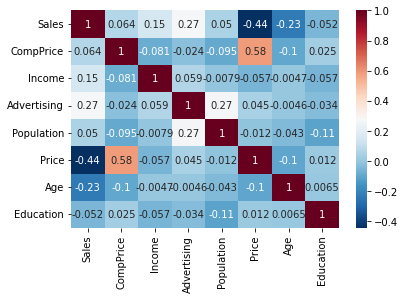

In [7]:
import seaborn as sns
df_corr = df.corr(method='pearson')
sns.heatmap(df_corr, cmap='RdBu_r', annot=True)

Sales 변수와 유의한 상관관계를 가진 변수는 없는 것으로 판단함

3. 종속변수를 Sales, 독립변수를 Comprice, Income, Adgertising, Population, Price, Age, Education으로 설정하고, 후진제거법을 활용하여 회귀분석을 실시하고 추정된 회귀식을 작성하시오.

In [48]:
import statsmodels.formula.api as smf

#일단 모든 변수를 선택하여 다 해본다.
indi_var_list = ["CompPrice", "Income", "Advertising", "Population", "Price", "Age", "Education"]
indi_var_formula = "+".join(indi_var_list)
model = smf.ols("Sales ~ "+indi_var_formula, df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     66.18
Date:                Tue, 06 Sep 2022   Prob (F-statistic):           1.41e-62
Time:                        01:23:26   Log-Likelihood:                -826.32
No. Observations:                 400   AIC:                             1669.
Df Residuals:                     392   BIC:                             1701.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.7077      1.118      6.896      0.000       5.510       9.905
CompPrice       0.0939      0.008     11.980      0.000       0.079       0.109
Income          0.0129      0.003      3.703      0.000       0.006       0.020
Advertising     0.1309      0.015      8.654      0.000       0.101       0.161
Population     -0.0001      0.001     -0.180      0.857      -0.001       0.001
Price          -0.0925      0.005    -18.314      0.000      -0.102      -0.083
Age            -0.0450      0.006     -7.485      0.000      -0.057      -0.033
Education      -0.0400      0.037     -1.077      0.282      -0.113       0.033
==============================================================================
Omnibus:                        8.263   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                7.705
Skew:                           0.288   Prob(JB):                       0.0212
Kurtosis:                       2.639   Cond. No.                     4.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
#후진제거법
def backward_elimination(df, dep_var, ind_vars, select_criteria = "AIC", return_case = "s"):
    alpha = 0.05
    selected_vars = ind_vars.copy()
    eliminated_vars = []
    done = False
    
    while done is False:
        #step1 : 변수 하나씩을 제외한 n개의 모델을 만들어낸다. (n : 변수 갯수)
        model_result_list = []
        for var in selected_vars:
            var_list = ind_vars.copy()
            if len(eliminated_vars)>0:
                for el_var in eliminated_vars:
                    var_list.remove(el_var)
            var_list.remove(var)
            this_ind_vars_str = " + ".join(var_list)
            this_model_fit = smf.ols(dep_var+" ~ "+this_ind_vars_str, data=df).fit()
            this_result = {
                "selected var" : this_ind_vars_str,
                "eliminated var" : var,            
                "AIC" : this_model_fit.aic,
                "rsquared_adj" : this_model_fit.rsquared_adj
            }
            model_result_list.append(this_result)
        result = pd.DataFrame(model_result_list)
        #step2 : n개 모델들 중 가장 좋은 결과를 보인 모델을 선택하고, 제외 후보 변수를 찾는다.
        ascending = True
        if select_criteria == "rsquared_adj":
            ascending = False
        result.sort_values(by=select_criteria, ascending=ascending, inplace=True)
        candidate_var = result.iloc[0, [1]].values[0]
        #step3 : 제외 후보 변수로 fitting하여 p-value를 알아보고 유의하다면 종료한다.
        candidate_model_fit = smf.ols(dep_var+" ~ "+candidate_var, data=df).fit()
        if candidate_model_fit.pvalues[candidate_var] > alpha: #유의하지 않다면
            eliminated_vars.append(candidate_var) #제거확정
            selected_vars.remove(candidate_var)
            print("{} 변수를 제거합니다.".format(candidate_var))
        else: #유의하다면 종료한다
            done = True
    if return_case == "s":
        print("후보 독립변수들 : {}".format(ind_vars))
        print("후진제거법에 의해 선택된 최종 변수들 : {}".format(selected_vars))
        return selected_vars
    elif return_case == "e":
        return eliminated_vars

indi_var_list = ["CompPrice", "Income", "Advertising", "Population", "Price", "Age", "Education"]
selected_vars = backward_elimination(df, "Sales", indi_var_list, "AIC")

#후진 제거법에 의해 선택된 변수만으로 회귀분석을 해본다.
indi_var_formula = "+".join(selected_vars)
model = smf.ols("Sales ~ "+indi_var_formula, df)
model.fit().summary()

Population 변수를 제거합니다.
Education 변수를 제거합니다.
후보 독립변수들 : ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']
후진제거법에 의해 선택된 최종 변수들 : ['CompPrice', 'Income', 'Advertising', 'Price', 'Age']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     92.62
Date:                Tue, 06 Sep 2022   Prob (F-statistic):           2.70e-64
Time:                        01:23:56   Log-Likelihood:                -826.92
No. Observations:                 400   AIC:                             1666.
Df Residuals:                     394   BIC:                             1690.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.1092      0.944      7.531      0.000       5.253       8.965
CompPrice       0.0939      0.008     12.051      0.000       0.079       0.109
Income          0.0131      0.003      3.779      0.000       0.006       0.020
Advertising     0.1306      0.015      8.963      0.000       0.102       0.159
Price          -0.0925      0.005    -18.347      0.000      -0.102      -0.083
Age            -0.0450      0.006     -7.503      0.000      -0.057      -0.033
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.154
Skew:                           0.288   Prob(JB):                       0.0170
Kurtosis:                       2.602   Cond. No.                     1.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ShapiroResult(statistic=0.9853094220161438, pvalue=0.00044237810652703047)


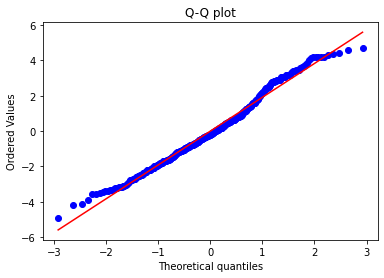

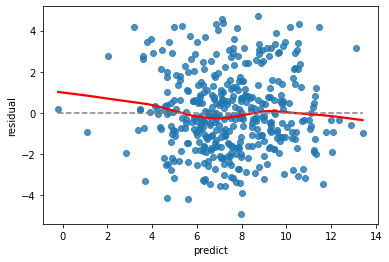

In [51]:
#잔차 분석을 수행해 본다.
import matplotlib.pyplot as plt
predict = model.fit().predict(df)
predict.name="predict"

residual = df["Sales"] - predict
residual.name="residual"

print(stats.shapiro(residual))

# 2. Q-Q plot으로 시각화하여 정규성 체크
#    X축은 정규분포곡선의 확률분포 위치값
#    Y축은 잔차가 정규분포곡선의 분포와 비교해 얼마나 떨어져 있는지의 값
#    붉은선에서 벗어나 있으면(대각선이 아니면) 정규성 없다고 봄

stats.probplot(residual, plot=plt)
plt.title("Q-Q plot")
plt.show()

#잔차의 등분산성 검증
#붉은색 선이 직선에 가까우면 등분산으로 볼 수 있음
sns.regplot(x=predict, y=residual, lowess=True, line_kws={'color': 'red'})
plt.plot([predict.min(), predict.max()], [0, 0], '--', color='grey')